> **In this noteook, we created separate tables for each model by selecting drugs based on a specific criteria.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/MRSA datasets

In [2]:
import pandas as pd
import numpy as np
from numpy import load
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import ListedColormap

In [5]:
dataset_path = '/content/drive/MyDrive/MRSA datasets/Datasets_fcgr'
tables_dir = 'Tables/Models Tables/'
graphs_dir = 'Tables/Label Distribution Graphs/'
Master_Table_filename = 'Tables/Master_Table.csv'

# Functions

In [4]:
get_sequence = lambda df, x: load(dataset_path + '/' + df['Species'][x] + '/' + df['Dataset'][x] + '/' + df['File Name'][x]+".npy")

labels_map = {'R': 0, 'I': 0, 'S': 1, np.nan: -1}

def count_samples(df):
    species_counts = df['Species'].value_counts()
    print(f"{'Species':<30} {'Samples':<10}")
    print('-'*40)
    for s, count in species_counts.items():
        print(f"{s:<30} {count}")
    print('-'*40)
    print(f"{'Total':<30} {len(df):<10}")
    return species_counts


def pct_dataframe(df, print_max = True):
    null_pct = ((df.isnull().sum()/len(df))*100).round(2)
    r_pct = ((((df == 'R' ) | (df == 'I')).sum()/df.notnull().sum())*100).round(2)
    s_pct = (((df == 'S').sum()/df.notnull().sum())*100).round(2)
    if(print_max):
        max_r = r_pct.max()
        max_r_drug = r_pct.idxmax()

        max_s = s_pct.max()
        max_s_drug = s_pct.idxmax()

        min_n = null_pct.min()
        min_n_drug = null_pct.idxmin()

        max_n = null_pct.max()
        max_n_drug = null_pct.idxmax()

        print(f"Minimum Null %: {min_n:.3f} in drug: {min_n_drug}")
        print(f"Maximum Null %: {max_n:.3f} in drug: {max_n_drug}\n")

        print(f"Maximum Resistance %: {max_r:.3f} in drug: {max_r_drug}")
        print(f"Maximum Sensitive %: {max_s:.3f} in drug: {max_s_drug}")
    return pd.DataFrame([null_pct, r_pct, s_pct], index=['Null %', 'Resistant %', 'Sensitive %'])

def pct_count_dataframe(df, print_max = True):
    null_pct = ((df.isnull().sum()/len(df))*100).round(2)
    r_pct = ((((df == 'R' ) | (df == 'I')).sum()/df.notnull().sum())*100).round(2)
    s_pct = (((df == 'S').sum()/df.notnull().sum())*100).round(2)

    r_count = ((df == 'R' ) | (df == 'I')).sum()
    s_count = (df == 'S').sum()

    if(print_max):
        max_r = r_pct.max()
        max_r_drug = r_pct.idxmax()

        max_s = s_pct.max()
        max_s_drug = s_pct.idxmax()

        min_n = null_pct.min()
        min_n_drug = null_pct.idxmin()

        max_n = null_pct.max()
        max_n_drug = null_pct.idxmax()

        print(f"Minimum Null %: {min_n:.3f} in drug: {min_n_drug}")
        print(f"Maximum Null %: {max_n:.3f} in drug: {max_n_drug}\n")

        print(f"Maximum Resistance %: {max_r:.3f} in drug: {max_r_drug}")
        print(f"Maximum Sensitive %: {max_s:.3f} in drug: {max_s_drug}")
    return pd.DataFrame([null_pct, r_pct, s_pct, r_count, s_count], index=['Null %', 'Resistant %', 'Sensitive %', 'R count', 'S count'])

def get_null_pct(df):
    null_count = df.isnull().sum().sum()
    total_val = df.shape[0] * df.shape[1]
    null_pct = null_count/total_val * 100
    return null_pct

def plot_bar_charts(df_pct, save = False, filename = '', fig_size = (16, 16)):
    fig, axes = plt.subplots(3, 1, figsize = fig_size)

    axes[0].axhline(y = 50, color = 'red', linestyle='--', linewidth = 2, label = '50% Threshold')
    axes[0].bar(df_pct.columns, df_pct.loc['Resistant %'], color = "#8E6998")
    axes[0].set_xlabel("Drugs")
    axes[0].set_ylabel("Resistant %")
    axes[0].tick_params(axis='x', rotation=82)

    axes[1].axhline(y = 50, color = 'red', linestyle='--', linewidth = 2, label = '50% Threshold')
    axes[1].bar(df_pct.columns, df_pct.loc['Sensitive %'], color = "#44a5c2")
    axes[1].set_xlabel("Drugs")
    axes[1].set_ylabel("Sensitive %")
    axes[1].tick_params(axis='x', rotation=82)

    x = np.arange(len(df_pct.columns))
    width = 0.2
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(df_pct.columns, rotation=82)
    axes[2].bar(x - width, df_pct.loc['Resistant %'], width, label='Resistant %', color="#8E6998")
    axes[2].bar(x , df_pct.loc['Sensitive %'], width, label='Sensitive %', color="#44a5c2")
    axes[2].bar(x + width, df_pct.loc['Null %'], width, label='Null %', color="#cccccc")
    axes[2].axhline(y = 50, color = 'red', linestyle='--', linewidth = 2, label = '50% Threshold')
    axes[2].set_xlabel("Drugs")
    axes[2].set_ylabel("Sensitive & Resistant %")
    axes[2].tick_params(axis='x', rotation=82)
    axes[2].legend()

    plt.tight_layout()
    if (save):
        plt.savefig(graphs_dir + filename, dpi=300, bbox_inches='tight')
    plt.show()

def select_drugs(df_pct, null_weight = 0.7, balance_score_weight = 0.3, null_score_threshold = 0.05, RS_ratio_threshold = 0.05):
    score = df_pct.copy().T
    score['null_score'] = 1 - score['Null %']/100

    score['R/S ratio'] = np.where(score['Sensitive %'] != 0, score['Resistant %'] / score['Sensitive %'], 0)
    score['balance_score'] = 1 - abs(score['R/S ratio'] - 1)

    score['score'] = (
        null_weight * score['null_score'] +
        balance_score_weight * score['balance_score']
    )

    selected_drugs = score.sort_values(by = 'score', ascending = False)
    selected_drugs = selected_drugs[(selected_drugs['score'] > 0) & (selected_drugs['null_score'] > null_score_threshold) & (selected_drugs['R/S ratio'] > RS_ratio_threshold)]
    return selected_drugs

# Cleaning Master Table

In [ ]:
Master_Table=pd.read_csv(Master_Table_filename, low_memory = False)
species_counts = count_samples(Master_Table)

Species                        Samples   
----------------------------------------
Staphylococcus aureus          5929
Salmonella enterica            5084
Mycobacterium tuberculosis     3523
Escherichia coli               3112
Klebsiella pneumoniae          1556
Acinetobacter baumannii        859
----------------------------------------
Total                          20063     


In [ ]:
''' merging Amikacin/Kanamycin and Kanamycin/Tobramycin '''

print('Number of different labels for Amikacin/Kanamycin and Kanamycin/Tobramycin and Amikacin: ',
      len(Master_Table[(Master_Table['Amikacin'].notna()) &
            (Master_Table['Amikacin/Kanamycin'].notna()) &
            (Master_Table['Kanamycin/Tobramycin'].notna()) &
            (Master_Table['Amikacin'] != Master_Table['Amikacin/Kanamycin']) &
            (Master_Table['Amikacin'] != Master_Table['Kanamycin/Tobramycin']) &
            (Master_Table['Amikacin/Kanamycin'] != Master_Table['Kanamycin/Tobramycin'])]))

Master_Table_merged_col = Master_Table.copy()
merge_col = lambda x: 'R' if 'R' in x.values else 'I' if 'I' in x.values else 'S' if 'S' in x.values else np.nan
Master_Table_merged_col['Amikacin'] = Master_Table_merged_col[['Amikacin', 'Amikacin/Kanamycin', 'Kanamycin/Tobramycin']].apply(merge_col)
Master_Table_merged_col.drop(['Amikacin/Kanamycin', 'Kanamycin/Tobramycin'], axis = 1, inplace = True)
Master_Table = Master_Table_merged_col

# General Model

In [ ]:
Master_Table_dropped_species = Master_Table.copy()
species_to_drop = ['Mycobacterium tuberculosis', 'Acinetobacter baumannii', 'Klebsiella pneumoniae']
Master_Table_dropped_species = Master_Table_dropped_species[~Master_Table_dropped_species['Species'].isin(species_to_drop)]
Master_Table_dropped_species['Species'].unique()

Master_Table_cleaned =  Master_Table_dropped_species.copy()

## Selecting Drugs

### <font color="purple">Overall R%, S% and null%</font>

In [ ]:
drugs = Master_Table_cleaned.copy()
drugs.drop(['Species', 'Dataset', 'File Name'], axis = 1, inplace = True)
drugs_pct = pct_dataframe(drugs, False)

In [ ]:
null_weight = 0.7
balance_score_weight = 0.3

score = drugs_pct.copy().T
score['null_score'] = 1 - score['Null %']/100

score['R/S ratio'] = np.where(score['Sensitive %'] != 0, score['Resistant %'] / score['Sensitive %'], 0)
score['balance_score'] = 1 - abs(score['R/S ratio'] - 1)

score['score'] = (
    null_weight * score['null_score'] +
    balance_score_weight * score['balance_score']
)

selected_drugs = score.sort_values(by = 'score', ascending = False)
selected_drugs = selected_drugs[(selected_drugs['score'] > 0) & (selected_drugs['null_score'] > 0.05) & (selected_drugs['R/S ratio'] > 0.05)]
selected_drugs

,Null %,Resistant %,Sensitive %,null_score,R/S ratio,balance_score,score
Ciprofloxacin,15.57,19.94,80.06,0.8443,0.249063,0.249063,0.665729
Tetracycline,48.53,52.29,47.71,0.5147,1.095997,0.904003,0.631491
Ampicillin,50.35,42.56,57.44,0.4965,0.740947,0.740947,0.569834
Gentamicin,33.54,20.50,79.50,0.6646,0.257862,0.257862,0.542578
Erythromycin,66.02,45.63,54.37,0.3398,0.839250,0.839250,0.489635
Methicillin,72.20,55.37,44.63,0.2780,1.240645,0.759355,0.422406
Cefoxitin,52.69,21.69,78.31,0.4731,0.276976,0.276976,0.414263
Clindamycin,74.92,38.33,61.67,0.2508,0.621534,0.621534,0.362020
Trimethoprim,93.41,49.73,50.27,0.0659,0.989258,0.989258,0.342907
Trimethoprim-Sulfamethoxazole,55.19,7.41,92.59,0.4481,0.080030,0.080030,0.337679


In [ ]:
len(selected_drugs)

22

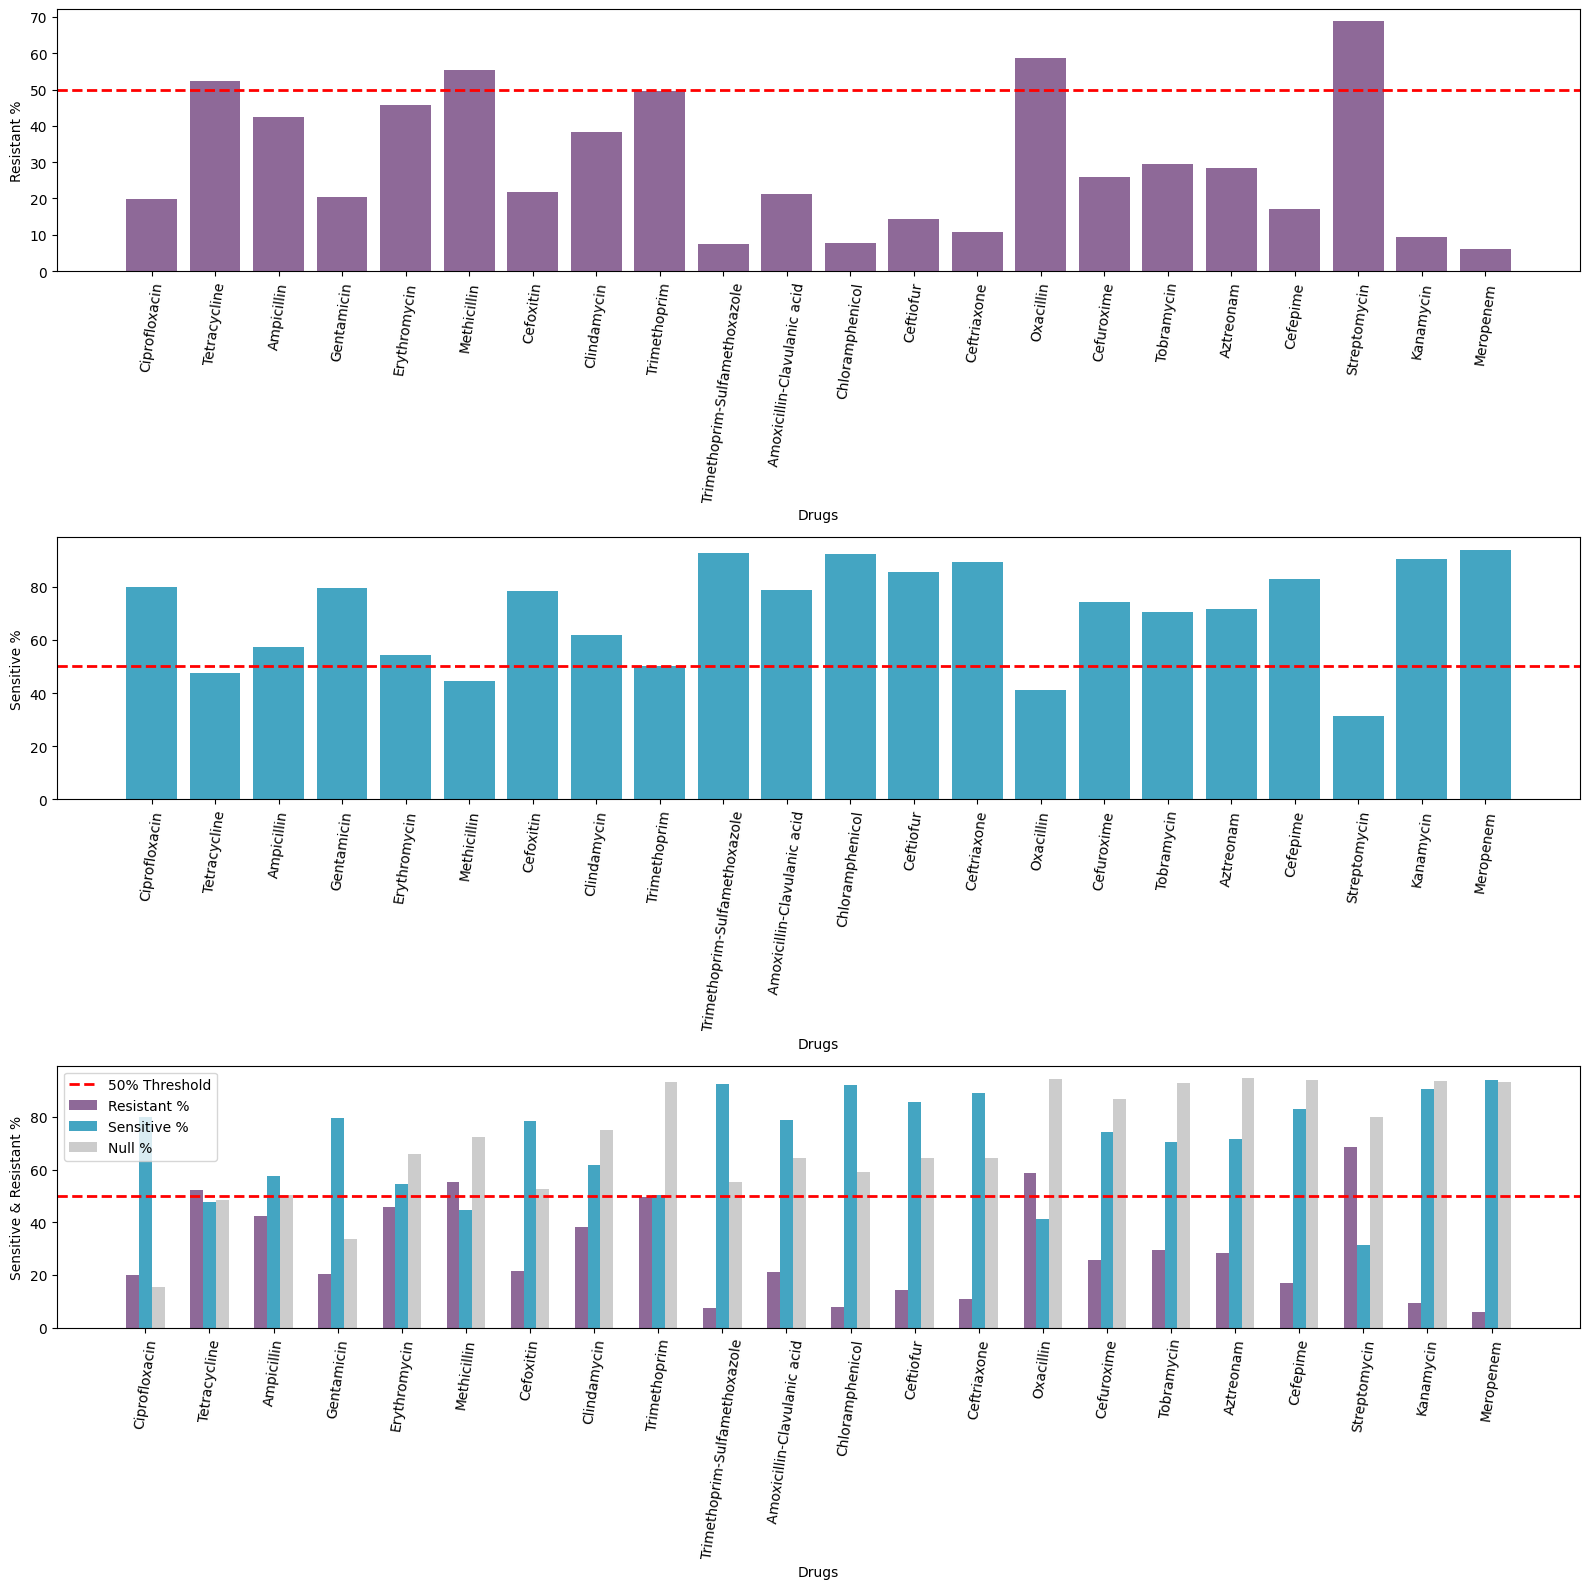

In [ ]:
plot_data = selected_drugs[['Resistant %', 'Sensitive %', 'Null %']].T
plot_bar_charts(plot_data)

In [ ]:
selected_drugs = np.array(selected_drugs.iloc[:4].index).tolist()

non_drug_cols = Master_Table_cleaned.columns[:3]
Master_Table_copy = Master_Table_cleaned.copy()

balanced_overall_classes_df = Master_Table_copy[list(non_drug_cols) + selected_drugs]
balanced_overall_classes_df = balanced_overall_classes_df.dropna(subset = selected_drugs, how = 'all')

count = count_samples(balanced_overall_classes_df)

Species                        Samples   
----------------------------------------
Salmonella enterica            5084
Staphylococcus aureus          4703
Escherichia coli               3101
----------------------------------------
Total                          12888     


### <font color="purple">Per species R and S count </font>

In [ ]:
count_threshold = 1

species = Master_Table_cleaned.copy()
species.drop(['Dataset', 'File Name'], axis=1, inplace=True)
species = species.replace(labels_map)
grouped = species.groupby('Species')


# Count 'R' and 'S' per column per species
value_counts = grouped.apply(lambda df: df.apply(lambda col: col.value_counts()))

value_counts = value_counts.fillna(0)

def get_columns_with_high_RS(df):
    r_counts = df.loc[0]
    s_counts = df.loc[1]

    mask = (r_counts > count_threshold) & (s_counts > count_threshold)
    return df.columns[mask].tolist()

# Apply this function for each species
columns_per_species = {}
for species_name in value_counts.index.get_level_values(0).unique():
    sub_df = value_counts.loc[species_name]
    columns_per_species[species_name] = get_columns_with_high_RS(sub_df)

common_drugs = set.intersection(*[set(a) for a in columns_per_species.values()])
list(common_drugs)

/tmp/ipython-input-2722407693.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  species = species.replace(labels_map)


['Tetracycline', 'Cefoxitin', 'Ciprofloxacin', 'Gentamicin']

In [ ]:
for k, v in columns_per_species.items():
    print(v)

['Gentamicin', 'Ciprofloxacin', 'Tetracycline', 'Trimethoprim', 'Cefoxitin', 'Cefepime', 'Levofloxacin', 'Meropenem', 'Tobramycin', 'Ampicillin', 'Aztreonam', 'Cefuroxime']
['Streptomycin', 'Ceftriaxone', 'Gentamicin', 'Trimethoprim-Sulfamethoxazole', 'Ciprofloxacin', 'Tetracycline', 'Chloramphenicol', 'Cefoxitin', 'Ampicillin', 'Amoxicillin-Clavulanic acid', 'Kanamycin', 'Nalidixic acid', 'Ceftiofur']
['Streptomycin', 'Macrolides', 'Vancomycin', 'Oxacillin', 'Clindamycin', 'Fusidic acid', 'Beta-lactam', 'Erythromycin', 'Linezolid', 'Methicillin', 'Gentamicin', 'Trimethoprim-Sulfamethoxazole', 'Fosfomycin', 'Ciprofloxacin', 'Tetracycline', 'Fluoroquinolones', 'Chloramphenicol', 'Penicillin', 'Trimethoprim', 'Lincosamide', 'Daptomycin', 'Cefoxitin']


### Specie wise R % and S %

In [ ]:
species_dfs = {species: group for species, group in balanced_overall_classes_df.groupby('Species')}

In [ ]:
species_df_pct = {}
species_drugs = {}
for s, df in species_dfs.items():
    pct_df = pct_dataframe(df, print_max=False)
    species_df_pct[s] = pct_df
    species_drugs[s] = select_drugs(pct_df)

In [ ]:
for s, df in species_drugs.items():
    print(df.index)

Index(['Ciprofloxacin', 'Gentamicin', 'Ampicillin', 'Tetracycline'], dtype='object')
Index(['Tetracycline', 'Ampicillin', 'Gentamicin'], dtype='object')
Index(['Ciprofloxacin', 'Gentamicin', 'Tetracycline'], dtype='object')


In [ ]:
common_drugs = set.intersection(*[set(a.T) for a in species_drugs.values()])
selected_drugs = list(common_drugs)
selected_drugs

['Tetracycline', 'Gentamicin']

## Final dataframe

In [ ]:
non_drug_cols = Master_Table_cleaned.columns[:3]
Master_Table_copy = Master_Table_cleaned.copy()

General_Model_Table = Master_Table_copy[list(non_drug_cols) + selected_drugs]
General_Model_Table = General_Model_Table.dropna(subset = selected_drugs, how = 'all')

count = count_samples(General_Model_Table)

Species                        Samples   
----------------------------------------
Salmonella enterica            5084
Staphylococcus aureus          2678
Escherichia coli               2432
----------------------------------------
Total                          10194     


Minimum Null %: 7.160 in drug: Gentamicin
Maximum Null %: 28.090 in drug: Tetracycline

Maximum Resistance %: 52.290 in drug: Tetracycline
Maximum Sensitive %: 79.500 in drug: Gentamicin


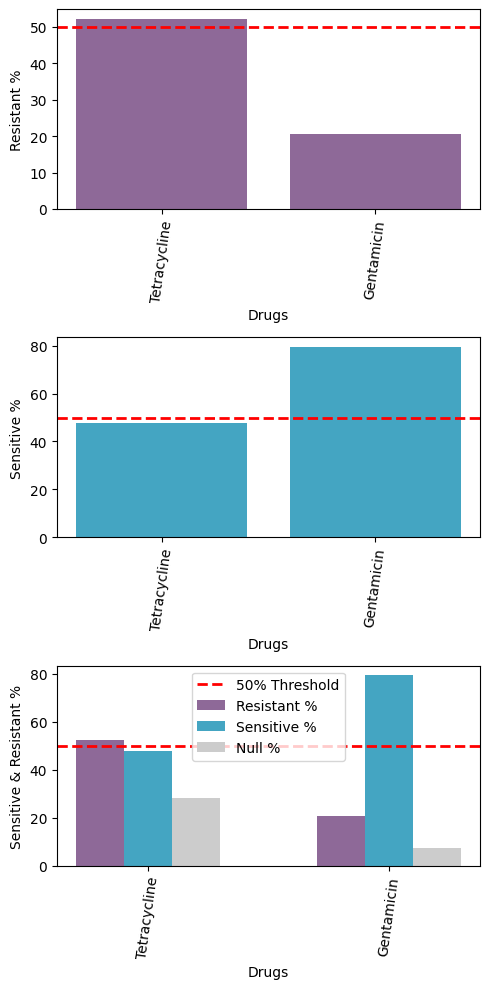

In [ ]:
general_pct = pct_dataframe(General_Model_Table.iloc[:, 3:])
plot_bar_charts(general_pct, True, 'General Model', (5, 10))

In [ ]:
General_Model_Table.to_csv(tables_dir + 'General_Model_Table.csv', index=False, sep=',', header=True, na_rep='N/A')

# Species Models

In [ ]:
species_included = ['Salmonella enterica', 'Staphylococcus aureus', 'Escherichia coli']
null_score_threshold = 0.8

In [ ]:
def select_species_drugs(species, null_score_threshold):
    species_df = Master_Table[Master_Table['Species'] == species]

    drugs = species_df.copy()
    drugs.drop(['Species', 'Dataset', 'File Name'], axis = 1, inplace = True)
    drugs_pct = pct_dataframe(drugs, False)
    select_drugs_df = select_drugs(drugs_pct, null_score_threshold = null_score_threshold)

    selected_drugs_list = np.array(select_drugs_df.index).tolist()
    non_drug_cols = species_df.columns[:3]

    species_df = species_df[list(non_drug_cols) + selected_drugs_list]
    species_df = species_df.dropna(subset = selected_drugs_list, how = 'all')
    species_df.to_csv(f'{tables_dir + species}_Model_Table.csv', index=False, sep=',', header=True, na_rep='N/A')

    return select_drugs_df

In [ ]:
salmonella_df = select_species_drugs('Salmonella enterica', 0.8)
salmonella_df

,Null %,Resistant %,Sensitive %,null_score,R/S ratio,balance_score,score
Tetracycline,0.0,55.43,44.57,1.0,1.243662,0.756338,0.926902
Ampicillin,0.0,29.92,70.08,1.0,0.426941,0.426941,0.828082
Amoxicillin-Clavulanic acid,0.0,21.24,78.76,1.0,0.269680,0.269680,0.780904
Cefoxitin,0.0,14.61,85.39,1.0,0.171097,0.171097,0.751329
Ceftiofur,0.0,14.30,85.70,1.0,0.166861,0.166861,0.750058
Gentamicin,0.0,13.61,86.39,1.0,0.157541,0.157541,0.747262
Ceftriaxone,0.0,10.84,89.16,1.0,0.121579,0.121579,0.736474
Chloramphenicol,0.0,4.82,95.18,1.0,0.050641,0.050641,0.715192


In [ ]:
staphylococcus_df = select_species_drugs('Staphylococcus aureus', 0.5)
staphylococcus_df

,Null %,Resistant %,Sensitive %,null_score,R/S ratio,balance_score,score
Erythromycin,19.94,45.63,54.37,0.8006,0.839250,0.839250,0.812195
Methicillin,34.50,55.37,44.63,0.6550,1.240645,0.759355,0.686306
Ciprofloxacin,25.23,33.55,66.45,0.7477,0.504891,0.504891,0.674857
Clindamycin,40.90,38.33,61.67,0.5910,0.621534,0.621534,0.600160
Penicillin,37.77,76.18,23.82,0.6223,3.198153,-1.198153,0.076164


In [ ]:
escherichia_df = select_species_drugs('Escherichia coli', 0.5)
escherichia_df

,Null %,Resistant %,Sensitive %,null_score,R/S ratio,balance_score,score
Ciprofloxacin,22.24,34.05,65.95,0.7776,0.516300,0.516300,0.699210
Gentamicin,22.85,17.70,82.30,0.7715,0.215067,0.215067,0.604570
Cefuroxime,38.85,25.85,74.15,0.6115,0.348618,0.348618,0.532635
Ampicillin,36.18,74.92,25.08,0.6382,2.987241,-0.987241,0.150568


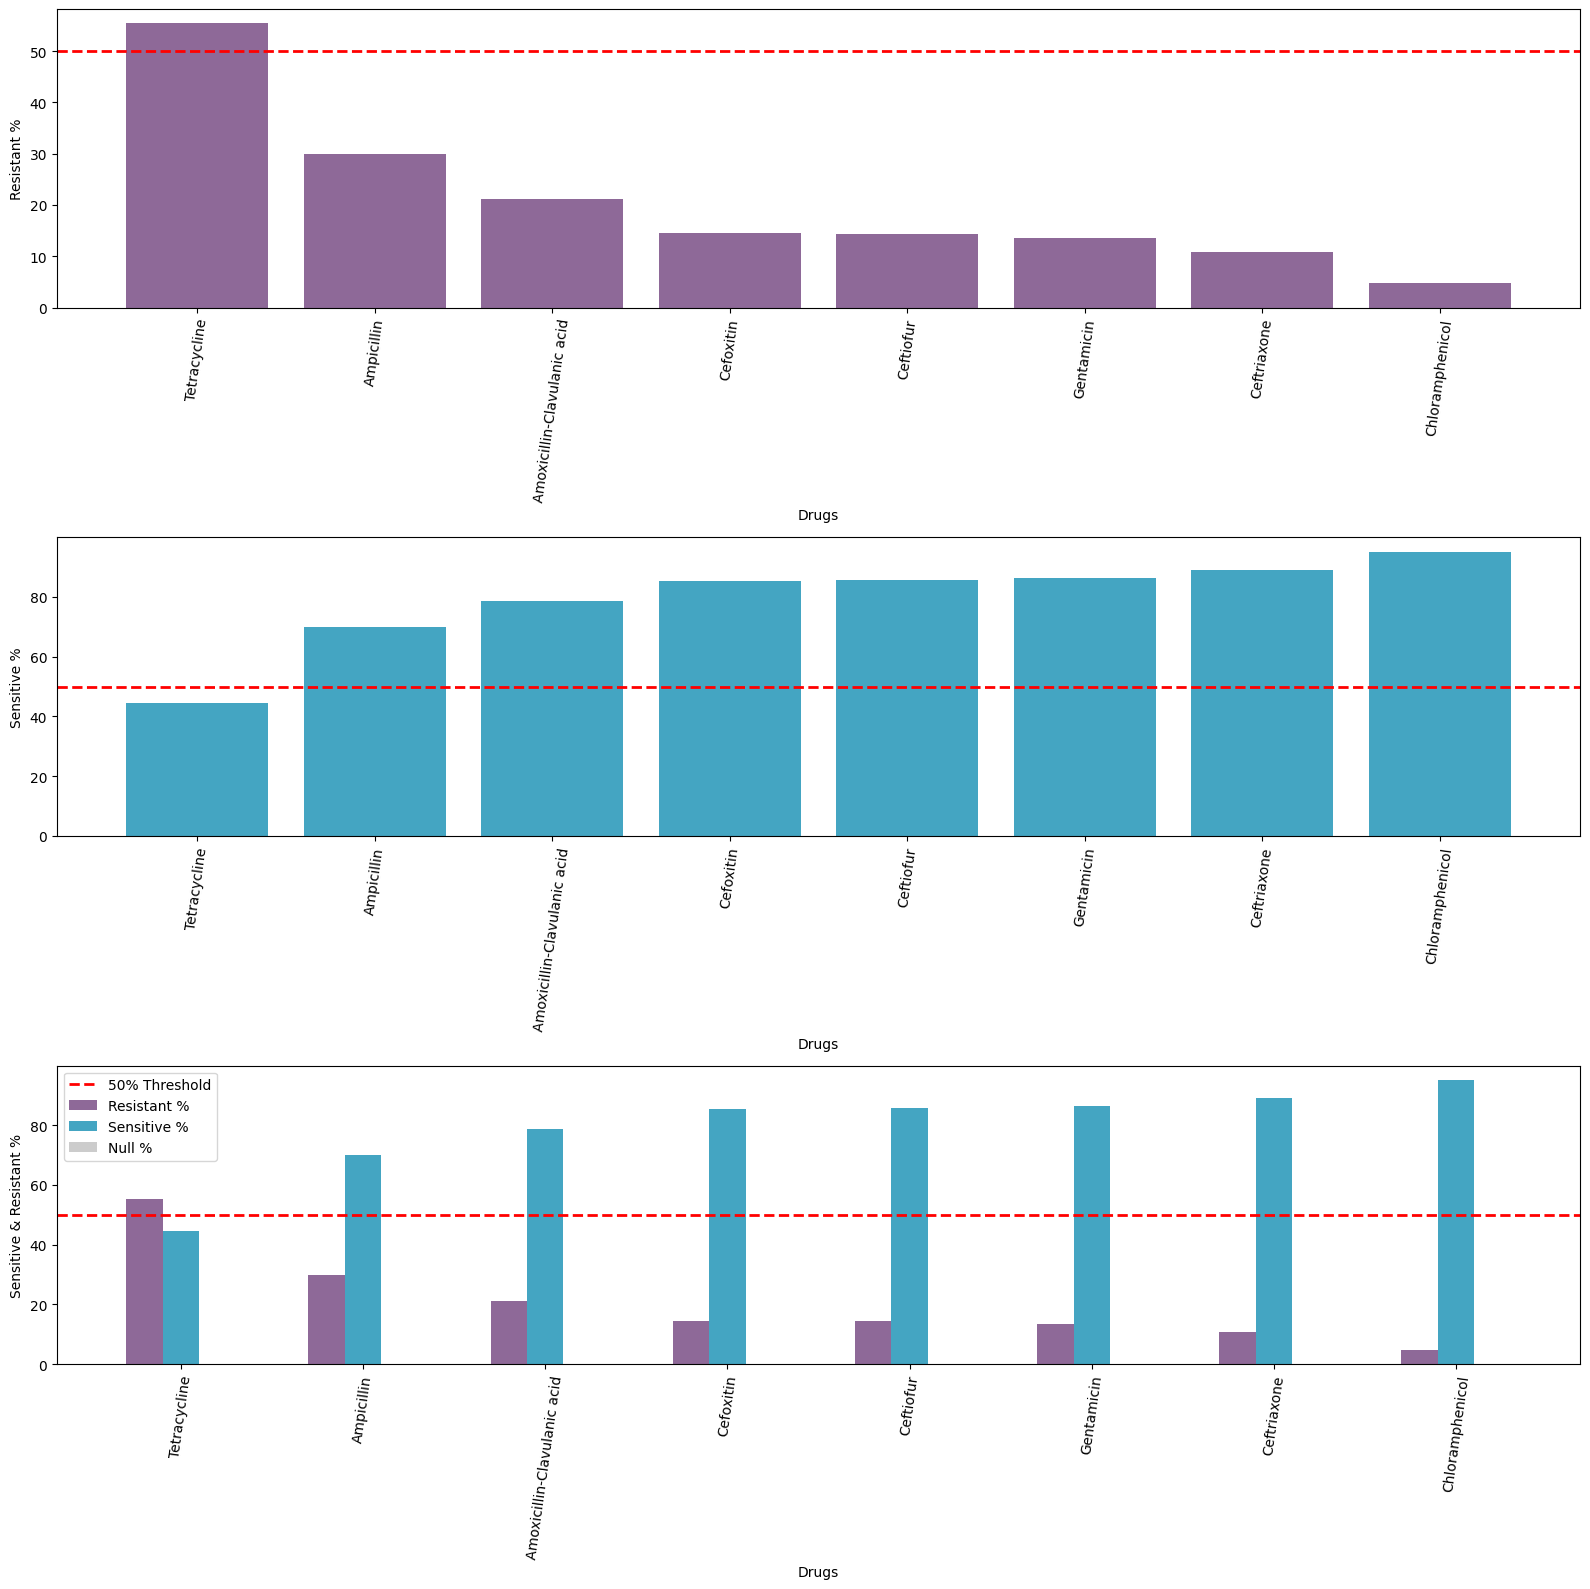

In [ ]:
plot_data = salmonella_df[['Resistant %', 'Sensitive %', 'Null %']].T
plot_bar_charts(plot_data, True, 'Salmonella enterica')

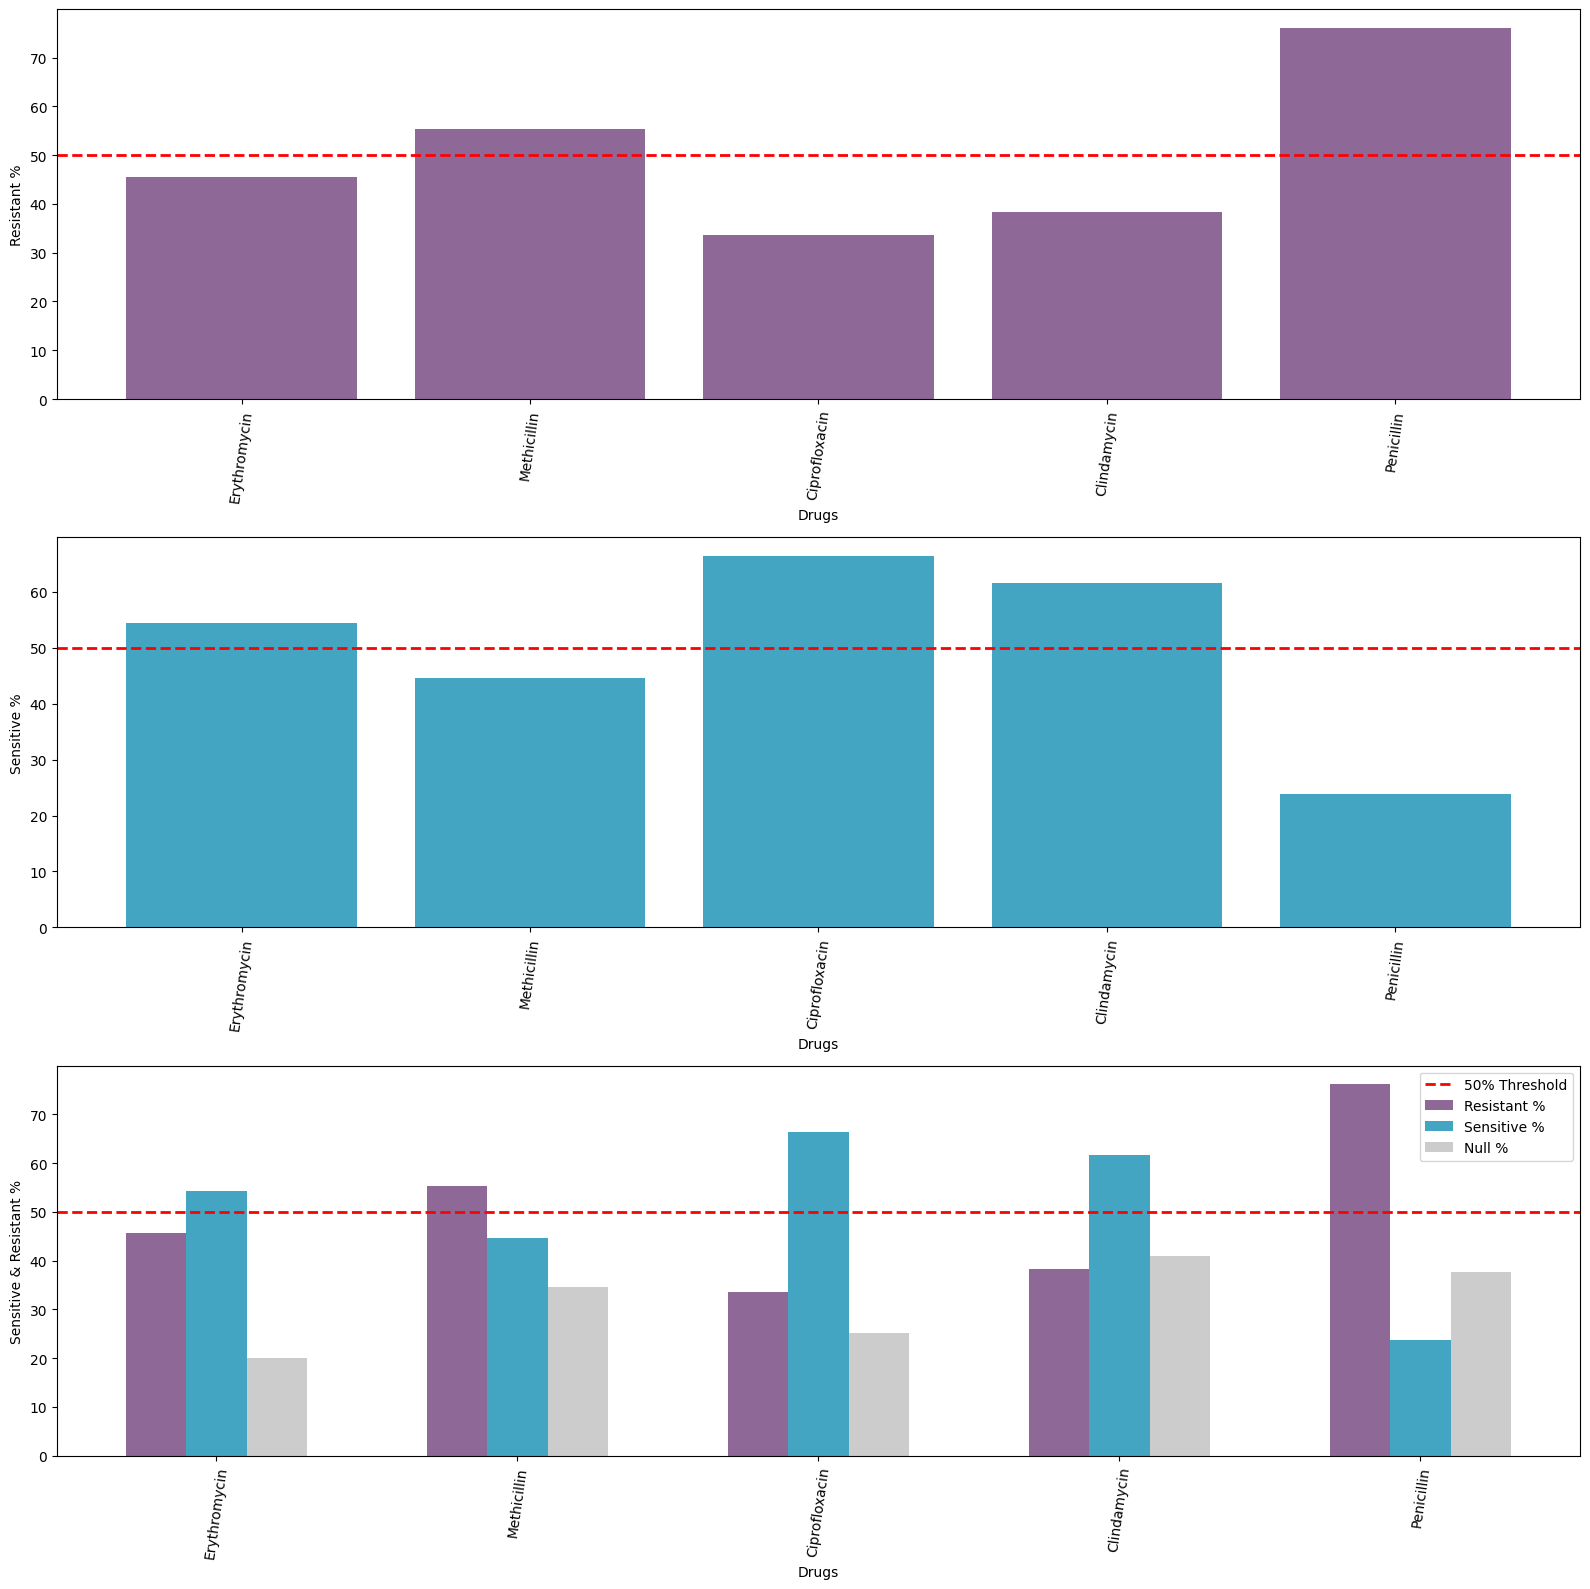

In [ ]:
plot_data = staphylococcus_df[['Resistant %', 'Sensitive %', 'Null %']].T
plot_bar_charts(plot_data, True, 'Staphylococcus aureus')

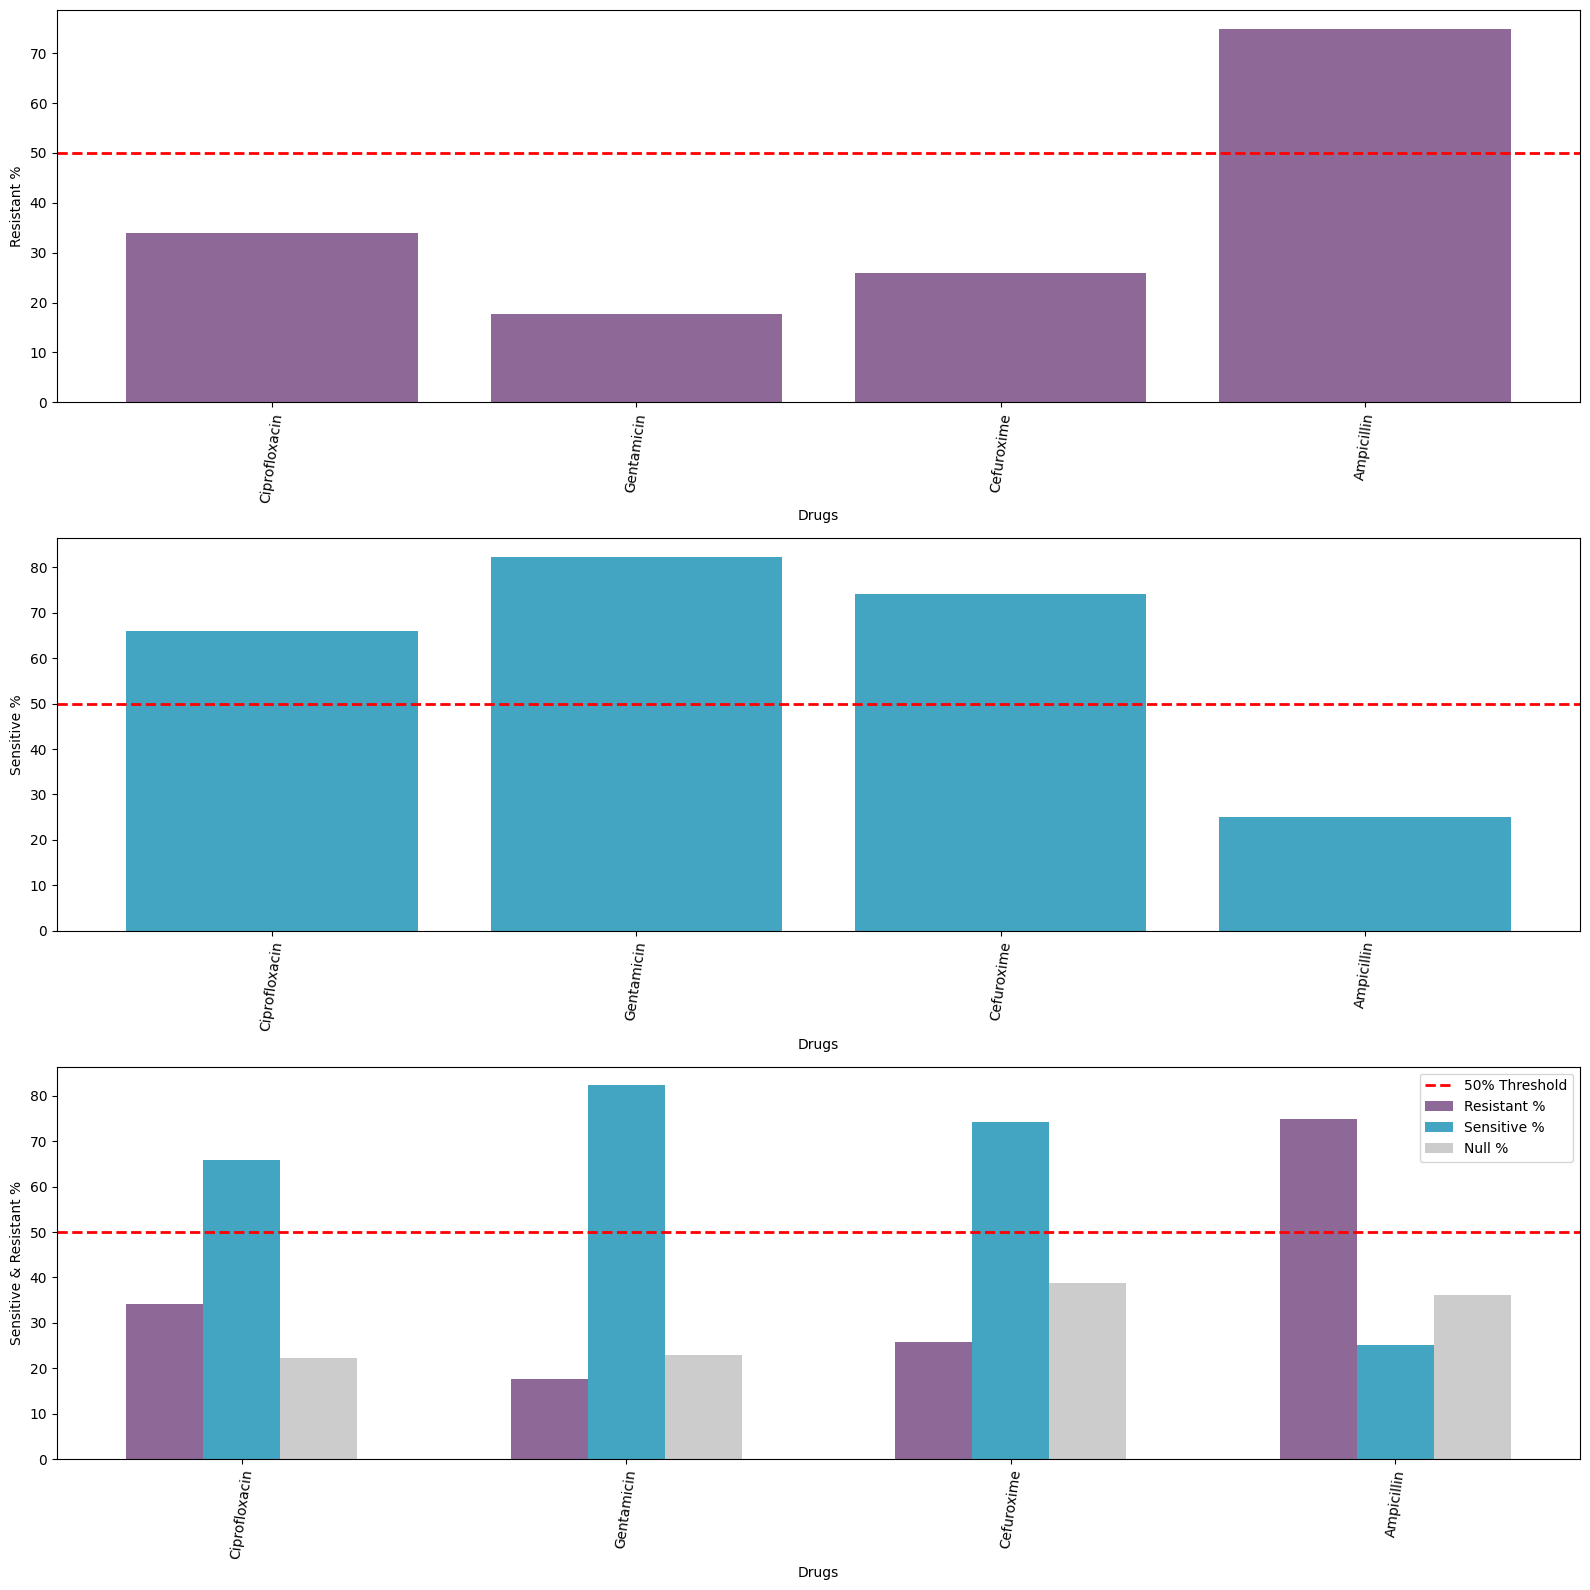

In [ ]:
plot_data = escherichia_df[['Resistant %', 'Sensitive %', 'Null %']].T
plot_bar_charts(plot_data, True, 'Escherichia coli')

# Dividing General Model

In [17]:
general = 'General_Model_Table_clusters.csv'
root_dir = '/content/drive/MyDrive/MRSA datasets/'
General_Model_Table = pd.read_csv(root_dir + tables_dir + general)

In [23]:
species_dfs = {species: group for species, group in General_Model_Table.groupby('Species')}
for key, df in species_dfs.items():
    df.to_csv(f'{root_dir + tables_dir + key}_Species_Model_Table.csv', index=False, sep=',', header=True, na_rep='N/A')
len(General_Model_Table['Dataset'].unique())

4

In [19]:
print(f"{'Species':<28} {'Samples':<12} {'Null %':<10}")
print('-'*50)
for name, df in species_dfs.items():
    print(f"{name:<30} {len(df):<10} {get_null_pct(species_dfs[name]):>5.2f}")
print(f"{'General Model':<30} {len(General_Model_Table):<10} {get_null_pct(General_Model_Table):>5.2f}")

Species                      Samples      Null %    
--------------------------------------------------
Escherichia coli               2432       14.54
Salmonella enterica            5084        0.00
Staphylococcus aureus          2563        9.57
General Model                  10079       5.94
